# Quantum Connection Setup

In [1]:
import netsquid as ns
from netsquid.nodes import DirectConnection, Node
from netsquid.components import FibreDelayModel, FibreLossModel, QuantumChannel, Message
from netsquid.components import DepolarNoiseModel, DephaseNoiseModel
from netsquid.protocols import NodeProtocol

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class SymmetricDirectConnection(DirectConnection):
    def __init__(self, name, L: int, loss_model, delay_model, noise_model) -> None:
        modelDict = {
            "delay_model": delay_model,
            "quantum_noise_model": noise_model,
            "quantum_loss_model": loss_model,
        }
        abChannel = QuantumChannel("A->B", length=L, models=modelDict)
        baChannel = QuantumChannel("B->A", length=L, models=modelDict)
        super().__init__(name, abChannel, baChannel)

# Protocols Definition (Sender, Receiver)

In [3]:
class SendProtocol(NodeProtocol):
    def __init__(self, node, stop_flag):
        super().__init__(node)
        self.qbitSent = 0
        self.stop_flag = stop_flag

    def run(self):
        port = self.node.ports["qubitIO"]
        while not self.stop_flag[0]:
            self.qbitSent += 1
            qubit_id = self.qbitSent

            qubit = ns.qubits.create_qubits(1)[0]
            msg = Message(items=[qubit], meta={"id": qubit_id})
            port.tx_output(msg)

            # Time in nanoseconds
            yield self.await_timer(50e6)  # 50 microseconds

In [4]:
class ReceiveProtocol(NodeProtocol):
    def __init__(self, node, stop_flag):
        super().__init__(node)
        self.arrival_time = None
        self.stop_flag = stop_flag
        self.received_id = None
        self.fidelity = None

    def run(self):
        port = self.node.ports["qubitIO"]
        # Wait (yield) until input has arrived on our port:
        yield self.await_port_input(port)
        self.stop_flag[0] = True
        current_time = ns.sim_time(magnitude=ns.MICROSECOND)
        self.arrival_time = current_time

        # We received a qubit.
        msg = port.rx_input()
        qubit = msg.items[0]
        self.received_id = msg.meta["meta"]["id"]

        # Calculate fidelity with respect to ideal state
        # By default, netsquid qubit is set to |0⟩ state
        ideal_state = ns.qubits.ketstates.s0  # |0⟩ state
        self.fidelity = ns.qubits.fidelity([qubit], ideal_state, squared=True)

# Node and Connection Creation

In [5]:
def create_directConnected_nodes(distance: int, p: list[float], depolar_freq):
    assert len(p) >= 2
    portName = "qubitIO"
    nodeA = Node("nodeA", port_names=[portName])
    nodeB = Node("nodeB", port_names=[portName])

    conn = SymmetricDirectConnection(
        "AB_channel",
        distance,
        FibreLossModel(p[0], p[1]),
        FibreDelayModel(),
        DepolarNoiseModel(depolar_rate=depolar_freq),
    )
    nodeA.connect_to(
        remote_node=nodeB,
        connection=conn,
        local_port_name=portName,
        remote_port_name=portName,
    )
    return nodeA, nodeB

# Simulation Setup

In [6]:
def setup_sim(
    n_simulations=100,
    distance=20,
    p_loss_init=0.0,
    p_loss_length=0.0,
    depolar_freq=10_000,
):
    """
    Setup and run a Netsquid simulation with specified parameters.
    
    Parameters:
    - distance (int): Distance between nodes in km.
    - p_loss_init (float): Initial loss probability.
    - p_loss_length (float): Loss probability per km.
    - depolar_freq (int): Depolarization frequency in Hz.

    Returns:
    - results (list of tuples): Each tuple contains
      (simulation_end_time, total_qubits_sent, arrival_time, fidelity) for each simulation
    """
    results = []
    for _ in range(n_simulations):
        ns.sim_reset()

        nodeA, nodeB = create_directConnected_nodes(
            distance, [p_loss_init, p_loss_length], depolar_freq
        )

        stop_flag = [False]  # Mutable flag to signal stopping
        AProtocol = SendProtocol(nodeA, stop_flag)
        BProtocol = ReceiveProtocol(nodeB, stop_flag)

        AProtocol.start()
        BProtocol.start()

        ns.util.SimStats = ns.sim_run(magnitude=ns.MICROSECOND)

        simulation_end_time = ns.sim_time(magnitude=ns.MICROSECOND)
        total_qubits_sent = BProtocol.received_id
        arrival_time = BProtocol.arrival_time
        fidelity = BProtocol.fidelity

        results.append((simulation_end_time, total_qubits_sent, arrival_time, fidelity))

    return results

# Analysis Functions

In [7]:
def sim_duration_stats(sim_end_times):
    # median simulation end time, that still has the delay in it from the sender
    simulation_end_times = sim_end_times.copy()
    simulation_end_times.sort()
    median_simulation_end_time = simulation_end_times[len(simulation_end_times) // 2]

    print("Simulation Time Statistics:")
    print(f"Median: {median_simulation_end_time} μs")
    print(f"Mean: {sum(simulation_end_times)/len(simulation_end_times):.4f}")
    print(f"Min: {min(simulation_end_times):.4f}")
    print(f"Max: {max(simulation_end_times):.4f}")

In [8]:
def qubits_stats(total_qubits_sent):
    # median qubits sent until reception
    qubits_sent = total_qubits_sent.copy()
    qubits_sent.sort()
    median_qubits_sent = qubits_sent[len(qubits_sent) // 2]

    print("Qubits Sent Statistics:")
    print(f"Median: {median_qubits_sent}")
    print(f"Mean: {sum(qubits_sent)/len(qubits_sent):.4f}")
    print(f"Min: {min(qubits_sent):.4f}")
    print(f"Max: {max(qubits_sent):.4f}")

In [9]:
def arrival_times_stats(arrival_times):
    # median arrival time
    arrival_times_temp = arrival_times.copy()
    arrival_times_temp.sort()
    median_arrival_time = arrival_times_temp[len(arrival_times_temp) // 2]

    print("Arrival Time Statistics:")
    print(f"Median: {median_arrival_time} μs")
    print(f"Mean: {sum(arrival_times_temp)/len(arrival_times_temp):.4f}")
    print(f"Min: {min(arrival_times_temp):.4f}")
    print(f"Max: {max(arrival_times_temp):.4f}")

In [10]:
def fidelity_stats(fidelities):
    # median fidelity
    fidelities_temp = fidelities.copy()
    fidelities_temp.sort()
    median_fidelity = fidelities_temp[len(fidelities_temp) // 2]

    print("Fidelity Statistics:")
    print(f"Median: {median_fidelity:.4f}")
    print(f"Mean: {sum(fidelities_temp)/len(fidelities_temp):.4f}")
    print(f"Min: {min(fidelities_temp):.4f}")
    print(f"Max: {max(fidelities_temp):.4f}")

In [11]:
def plot_pmf_arrival_times(arrival_times, bins, title):
    plt.figure(figsize=(10, 6))
    plt.hist(
        arrival_times,
        bins=bins,
        density=False,
        weights=[1 / len(arrival_times)] * len(arrival_times),
        alpha=0.7,
        edgecolor="black",
        color="steelblue",
    )
    plt.xlabel("Arrival Time (μs)", fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_cdf_arrival_times(arrival_times, title):
    arrival_times_sorted = sorted(arrival_times)
    n = len(arrival_times_sorted)
    probabilities = np.arange(1, n + 1) / n

    plt.figure(figsize=(10, 6))
    plt.plot(arrival_times_sorted, probabilities, linewidth=2, color="steelblue")
    plt.xlabel("Time (μs)", fontsize=12)
    plt.ylabel("P(Arrival Time ≤ t)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [13]:
def plot_fidelity_distribution(fidelities, bins, title):
    plt.figure(figsize=(10, 6))
    plt.hist(
        fidelities,
        bins=bins,
        density=False,
        weights=[1 / len(fidelities)] * len(fidelities),
        alpha=0.7,
        edgecolor="black",
        color="coral",
    )
    plt.axvline(
        x=0.9,
        color="red",
        linestyle="--",
        linewidth=2,
        label="Quality threshold (F=0.9)",
    )
    plt.xlabel("Fidelity", fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run Simulation

In [ ]:
# Define different parameter sets to test
param_sets = [
    # Base case
    {
        "distance": 20,
        "p_loss_init": 0.02,
        "p_loss_length": 0.003,
        "depolar_freq": 5_000,
        "label": "Base case (20km, 0.02 init, 0.003/km, 5kHz)",
    },
    # Some strong loss values
    {
        "distance": 20,
        "p_loss_init": 0.2,
        "p_loss_length": 0.2,
        "depolar_freq": 5_000,
        "label": "Base case (20km, 0.2 init, 0.2/km, 5kHz)",
    },
    # # Low-loss fibre (better hardware)
    # {
    #     "distance": 20,
    #     "p_loss_init": 0.01,
    #     "p_loss_length": 0.0015,
    #     "depolar_freq": 3_000,
    #     "label": "Low-loss fibre (20km, 0.01 init, 0.0015/km, 3kHz)",
    # },
    # # High-loss fibre (older hardware)
    # {
    #     "distance": 20,
    #     "p_loss_init": 0.05,
    #     "p_loss_length": 0.005,
    #     "depolar_freq": 3_000,
    #     "label": "High-loss fibre (20km, 0.05 init, 0.005/km, 3kHz)",
    # },
    # # Noise-dominated (bad coherence, good fibre)
    # {
    #     "distance": 20,
    #     "p_loss_init": 0.05,
    #     "p_loss_length": 0.005,
    #     "depolar_freq": 5_000,
    #     "label": "Noise-dominated (20km, 0.05 init, 0.005/km, 5kHz)",
    # },
    # # Clean fibre, noisy source
    # {
    #     "distance": 20,
    #     "p_loss_init": 0.01,
    #     "p_loss_length": 0.001,
    #     "depolar_freq": 80_000,
    #     "label": "Clean fibre, noisy source (20km, 0.01 init, 0.001/km, 80kHz)",
    # },
    # # Longer distance (50km)
    # {
    #     "distance": 50,
    #     "p_loss_init": 0.02,
    #     "p_loss_length": 0.003,
    #     "depolar_freq": 5_000,
    #     "label": "Long distance (50km, 0.02 init, 0.003/km, 5kHz)",
    # },
    # # Long-distance with realistic fibre (100km)
    # {
    #     "distance": 100,
    #     "p_loss_init": 0.02,
    #     "p_loss_length": 0.0022,
    #     "depolar_freq": 3_000,
    #     "label": "Long distance (100km, 0.02 init, 0.0022/km, 3kHz)",
    # },
    # # Very long-distance (150km), optimized fibre
    # {
    #     "distance": 150,
    #     "p_loss_init": 0.01,
    #     "p_loss_length": 0.0015,
    #     "depolar_freq": 2_000,
    #     "label": "Very long distance (150km, 0.01 init, 0.0015/km, 2kHz)",
    # },
    # # Same distance, different depolarization rates
    # {
    #     "distance": 20,
    #     "p_loss_init": 0.02,
    #     "p_loss_length": 0.003,
    #     "depolar_freq": 1000,
    #     "label": "Low depolarization (20km, 0.02 init, 0.003/km, 1kHz)",
    # },
    # {
    #     "distance": 20,
    #     "p_loss_init": 0.02,
    #     "p_loss_length": 0.003,
    #     "depolar_freq": 5_000,
    #     "label": "High depolarization (20km, 0.02 init, 0.003/km, 5kHz)",
    # },
    # {
    #     "distance": 20,
    #     "p_loss_init": 0.02,
    #     "p_loss_length": 0.003,
    #     "depolar_freq": 50_000,
    #     "label": "High depolarization (20km, 0.02 init, 0.003/km, 50kHz)",
    # },
    # {
    #     "distance": 20,
    #     "p_loss_init": 0.02,
    #     "p_loss_length": 0.003,
    #     "depolar_freq": 200_000,
    #     "label": "High depolarization (20km, 0.02 init, 0.003/km, 200kHz)",
    # },
]

# Run simulations for all parameter sets
all_results = {}
n_sims = 2000  # Reduce for faster testing

print("Running simulations with different parameters...")
for i, params in enumerate(param_sets):
    print(f"Running set {i+1}/{len(param_sets)}: {params['label']}")

    results = setup_sim(
        n_simulations=n_sims,
        distance=params["distance"],
        p_loss_init=params["p_loss_init"],
        p_loss_length=params["p_loss_length"],
        depolar_freq=params["depolar_freq"],
    )

    all_results[params["label"]] = {
        "params": params,
        "sim_end_times": [res[0] for res in results],
        "total_qubits_sent": [res[1] for res in results],
        "arrival_times": [res[2] for res in results],
        "fidelities": [res[3] for res in results],
    }

print("All simulations completed!")

Running simulations with different parameters...
Running set 1/1: Base case (20km, 0.02 init, 0.003/km, 5kHz)
All simulations completed!



=== Base case (20km, 0.02 init, 0.003/km, 5kHz) ===
Simulation Time Statistics:
Median: 50000.0 μs
Mean: 52050.0000
Min: 50000.0000
Max: 150000.0000
Qubits Sent Statistics:
Median: 1
Mean: 1.0410
Min: 1.0000
Max: 3.0000
Arrival Time Statistics:
Median: 100.0 μs
Mean: 2150.0000
Min: 100.0000
Max: 100100.0000
Fidelity Statistics:
Median: 1.0000
Mean: 0.7850
Min: 0.0000
Max: 1.0000


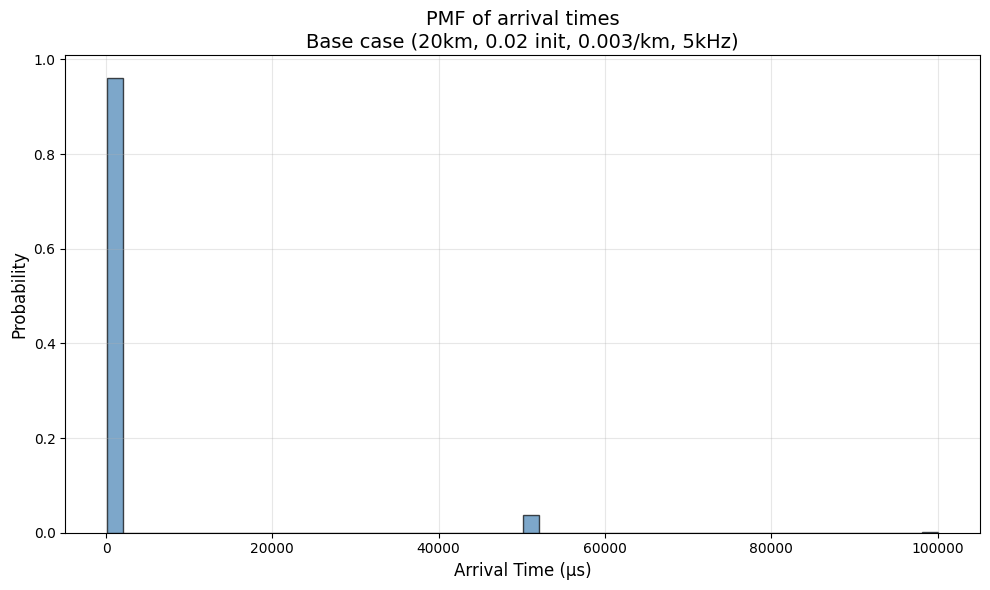

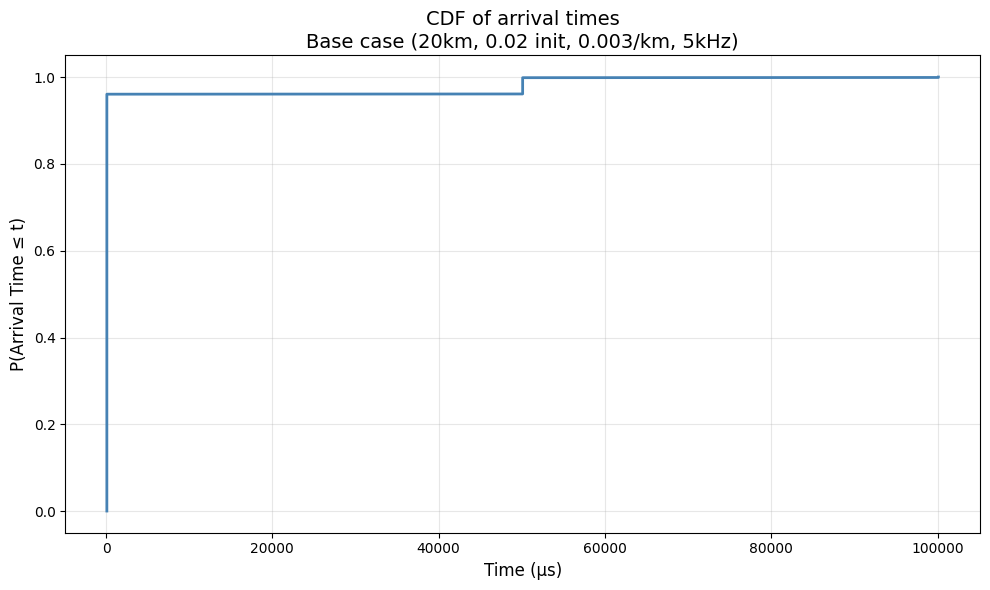

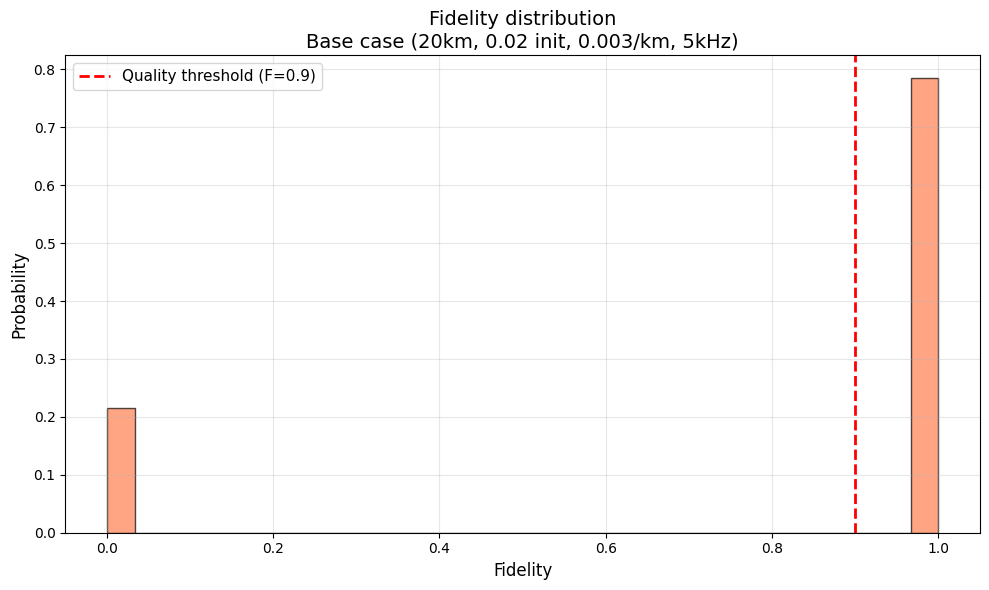

In [20]:
for label, data in all_results.items():
    print(f"\n=== {label} ===")
    sim_end_times = data["sim_end_times"]
    total_qubits_sent = data["total_qubits_sent"]
    arrival_times = data["arrival_times"]
    fidelities = data["fidelities"]

    # Print stats
    sim_duration_stats(sim_end_times)
    qubits_stats(total_qubits_sent)
    arrival_times_stats(arrival_times)
    fidelity_stats(fidelities)

    # Plots (one figure per metric per set)
    plot_pmf_arrival_times(
        arrival_times, bins=50, title=f"PMF of arrival times\n{label}"
    )
    plot_cdf_arrival_times(arrival_times, title=f"CDF of arrival times\n{label}")
    plot_fidelity_distribution(
        fidelities, bins=30, title=f"Fidelity distribution\n{label}"
    )